# FCA sn analysis for FEMALES - clusters identification and characterization

In [9]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import os
import sys

def MovePlots(plotpattern, subplotdir):
    os.system('mkdir -p '+str(sc.settings.figdir)+'/'+subplotdir)
    os.system('mv '+str(sc.settings.figdir)+'/*'+plotpattern+'** '+str(sc.settings.figdir)+'/'+subplotdir)

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.figdir = './figures-sn/clustering_females/'
sc.settings.set_figure_params(dpi=80)  # low dpi (dots per inch) yields small inline figures

sys.executable

'/home/jovyan/my-conda-envs/sc_analysis/bin/python'

## Load data

In [10]:
path2gonads = '/nfs/users/nfs_l/lg18/team292/lg18/with_valentina/gonadsV2_revision/'
adata = sc.read(path2gonads+'multiomics_rna_counts_denoised_Hrv58.h5ad')
adata.X.shape

(6269, 33997)

## Filter females

In [11]:
adata = adata[[ i in ['Hrv58'] for i in adata.obs['donor']]]

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [12]:
print('Total number of cells: {:d}'.format(adata.n_obs))
print('Total number of genes: {:d}'.format(adata.n_vars))

Total number of cells: 6269
Total number of genes: 33997


In [13]:
sc.pp.filter_genes(adata, min_cells=3)

filtered out 2677 genes that are detected in less than 3 cells
Trying to set attribute `.var` of view, copying.


### Identify HVGs

In [14]:
sc.pp.highly_variable_genes(adata, flavor='seurat_v3', n_top_genes=2000, subset=False)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:144: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[: int(n_top_genes), 'highly_variable'] = True
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [15]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
filtered out 14 cells that have less than 1 counts
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Score cell cycle

In [16]:
s_genes = [x.strip() for x in open('/home/jovyan/utils/S_genes.tsv')]
g2m_genes = [x.strip() for x in open('/home/jovyan/utils/G2M_genes.tsv')]

s_genes = [x for x in s_genes if x in adata.var_names]
g2m_genes = [x for x in g2m_genes if x in adata.var_names]

In [17]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    460 total control genes are used. (0:00:00)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    503 total control genes are used. (0:00:00)
-->     'phase', cell cycle phase (adata.obs)


### Normalize per cell and log transform

After removing unwanted cells and genes from the dataset, the next step is to normalize the data. 
By default, we employ a global-scaling normalization method “LogNormalize” that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. 

In [18]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

normalizing by total count per cell
/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


### Filter HVGs in bdata and do PCA with them

In [19]:
bdata = adata[:, adata.var['highly_variable']]
print('Total number of cells: {:d}'.format(bdata.n_obs))
print('Total number of genes: {:d}'.format(bdata.n_vars))

Total number of cells: 6255
Total number of genes: 2000


/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [20]:
sc.pp.scale(bdata, max_value=10)
sc.tl.pca(bdata, svd_solver='arpack', n_comps=50)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:810: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)


## Transfer PCA to the main adata

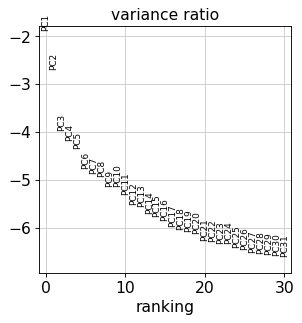

In [21]:
#fill NaNs with False so that subsetting to HVGs is possible
adata.var['highly_variable'].fillna(value=False, inplace=True)
adata.obsm['X_pca'] = bdata.obsm['X_pca'].copy()
adata.uns['pca'] = bdata.uns['pca'].copy()
adata.varm['PCs'] = np.zeros(shape=(adata.n_vars, 50))
adata.varm['PCs'][adata.var['highly_variable']] = bdata.varm['PCs']
sc.pl.pca_variance_ratio(adata, log=True, save='.pdf')

### UMAP

In [22]:
n_pcs = 20

In [23]:
# Visualize
sc.pp.neighbors(adata, n_pcs = n_pcs)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


## Clustering the graph
As Seurat and many others, we use the leiden graph-clustering method (community detection based on optimizing modularity). It has been proposed for single-cell data by Levine et al. (2015).

In [24]:
sc.tl.leiden(adata, resolution=0.3)
# sc.tl.leiden(adata, resolution=0.2)

running Leiden clustering
    finished: found 12 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


... storing 'phase' as categorical


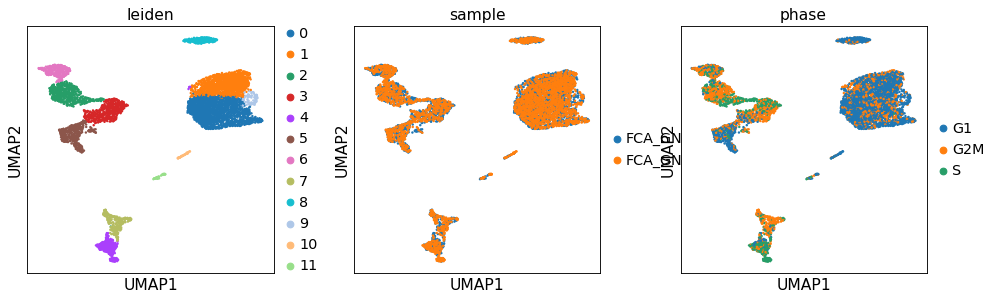

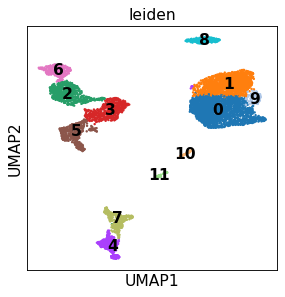

In [25]:
sc.pl.umap(adata, color=['leiden', 'sample', 'phase'] )
sc.pl.umap(adata, color=['leiden'],legend_loc='on data')

running Leiden clustering
    finished: found 13 clusters and added
    'leiden_R', the cluster labels (adata.obs, categorical) (0:00:00)


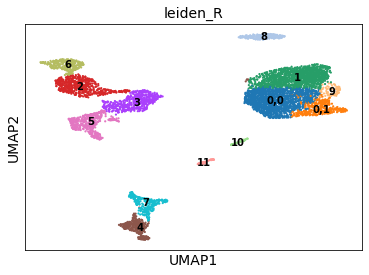

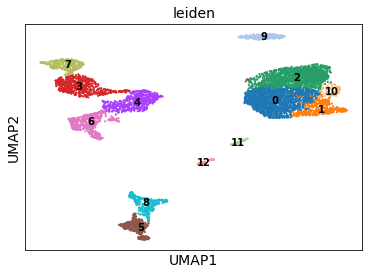

In [44]:
sc.tl.leiden(adata, resolution=0.15, restrict_to=('leiden', ['0']))
sc.pl.umap(adata, color='leiden_R',legend_loc='on data')
adata.obs['leiden_R'].cat.categories = [str(i) for i in range(len(adata.obs['leiden_R'].cat.categories))]
adata.obs['leiden'] = adata.obs['leiden_R']
sc.pl.umap(adata, color='leiden',legend_loc='on data')

### Visualize general markers

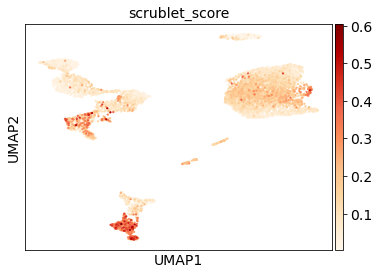

In [45]:
sc.pl.umap(adata, color=['scrublet_score'], color_map='OrRd')

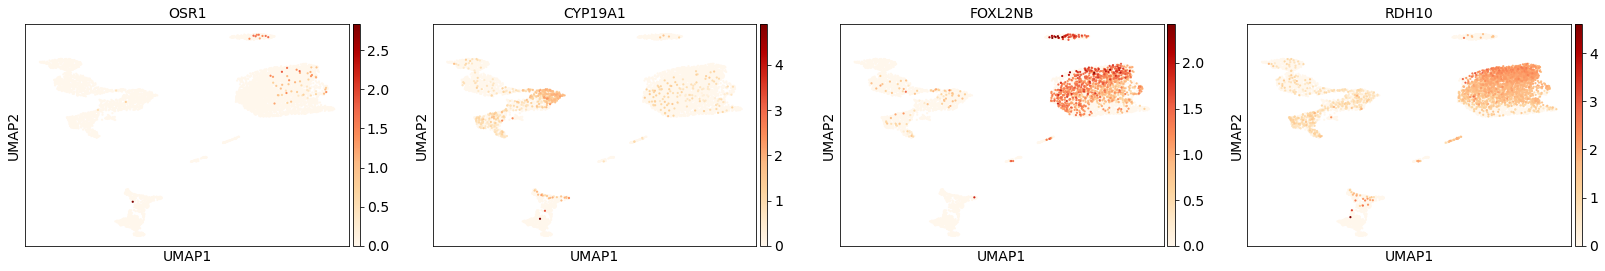

In [46]:
sc.pl.umap(adata, color=["OSR1", 'CYP19A1', 'FOXL2NB', 'RDH10'], color_map='OrRd', use_raw=False )

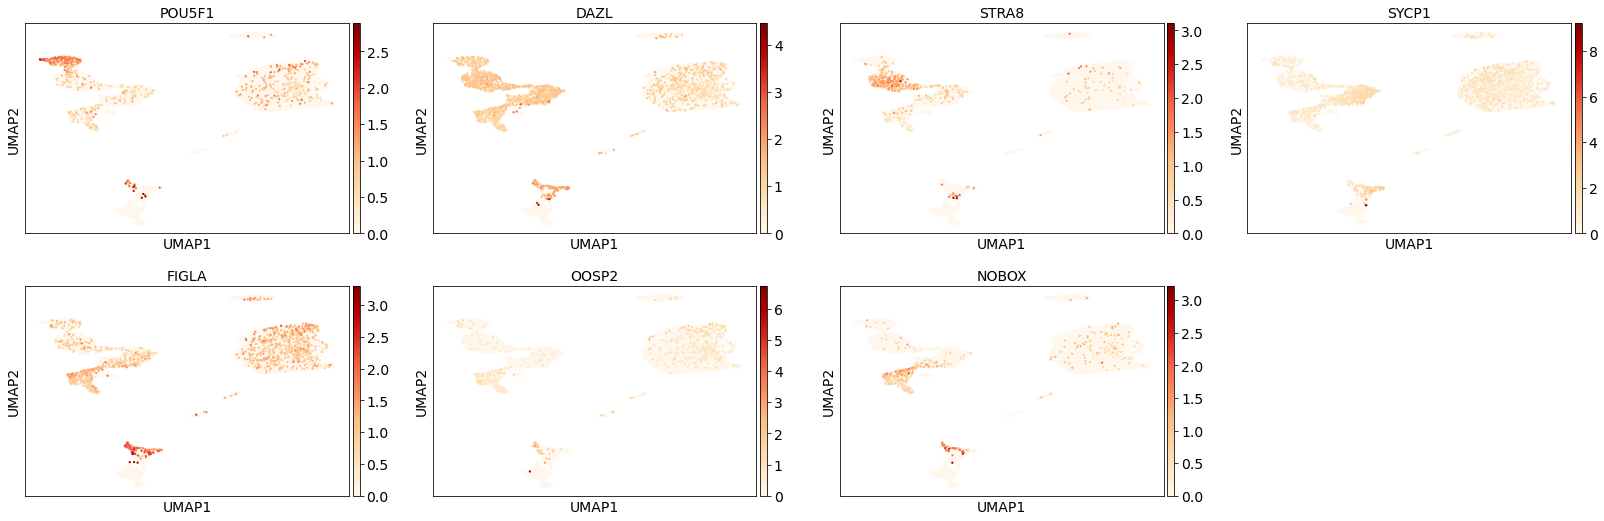

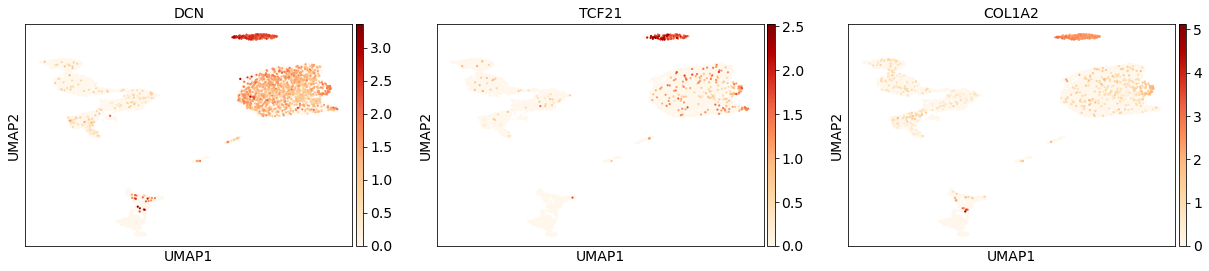

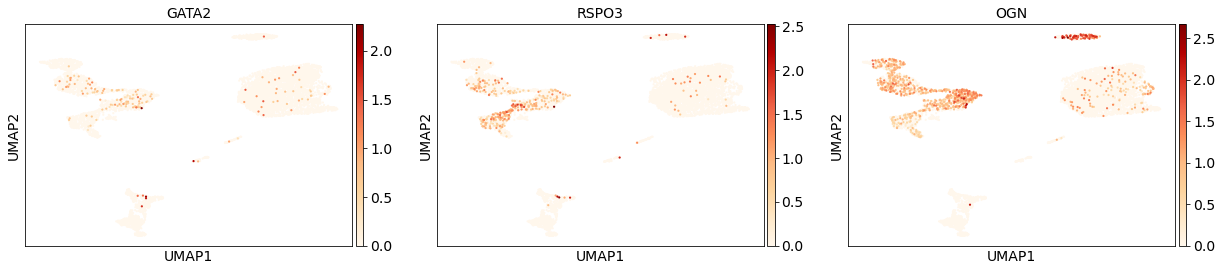

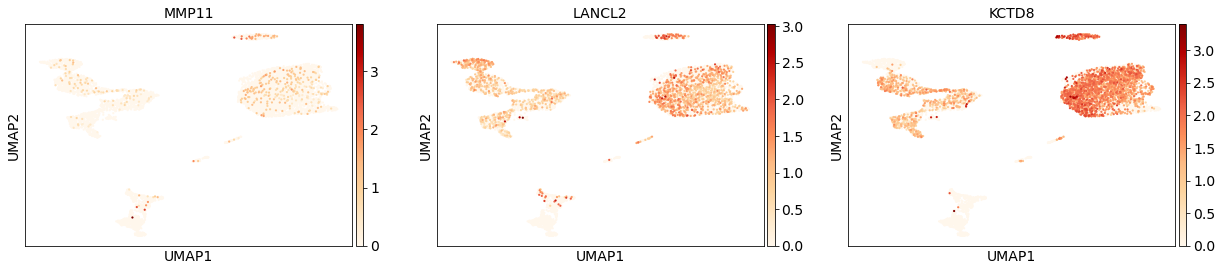

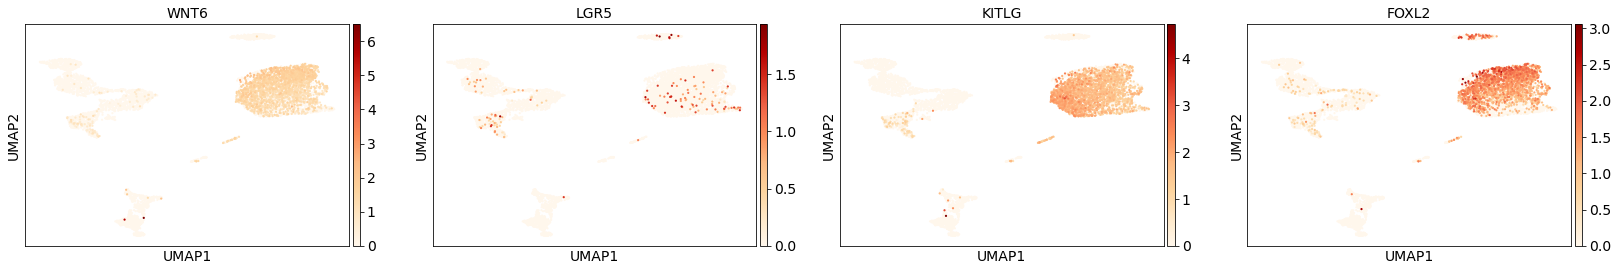

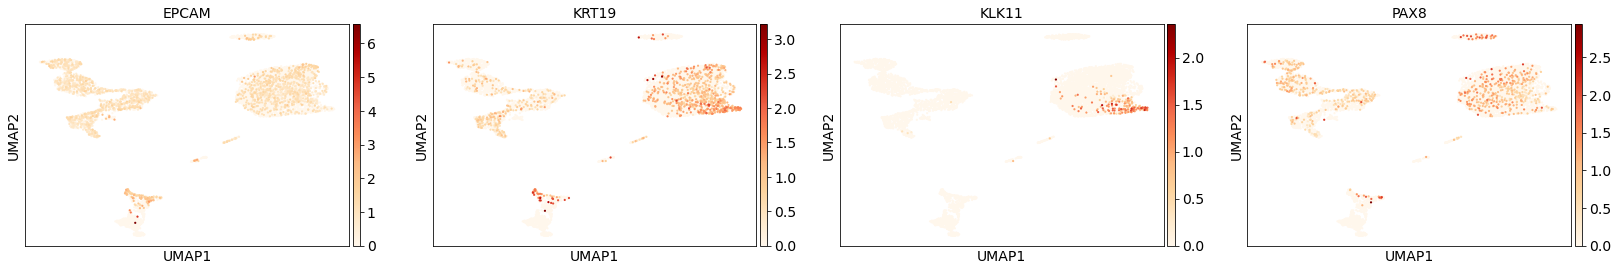

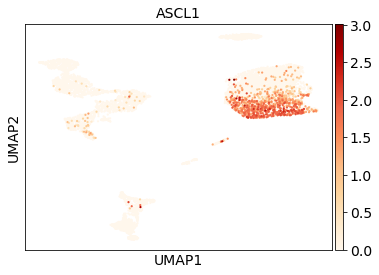

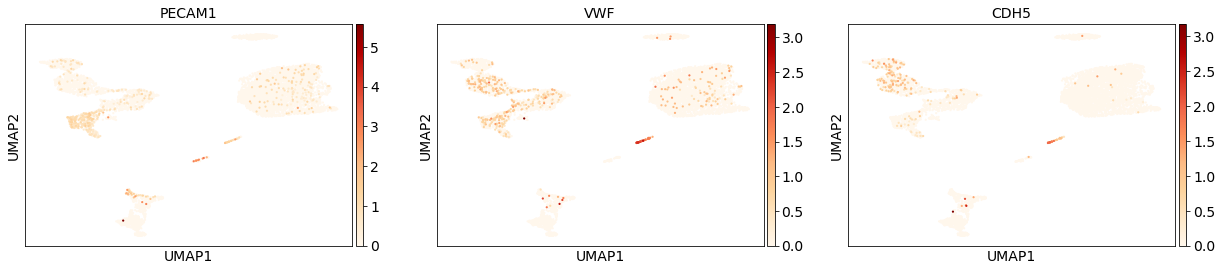

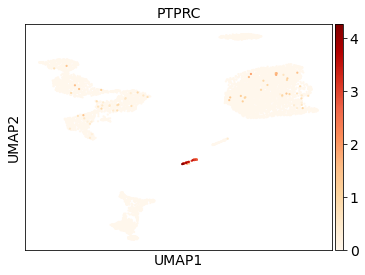

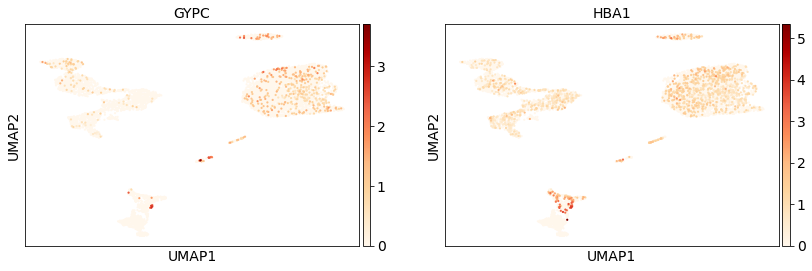

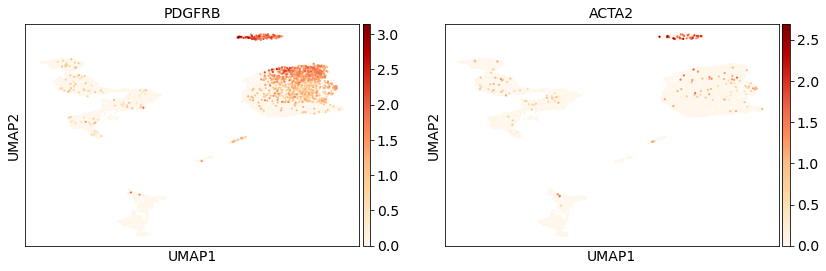

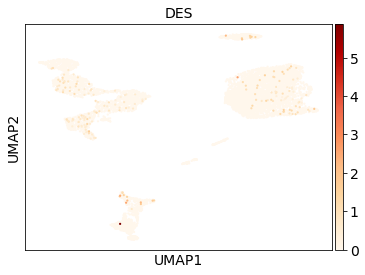

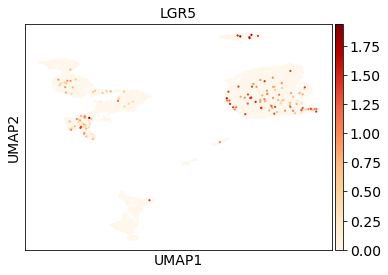

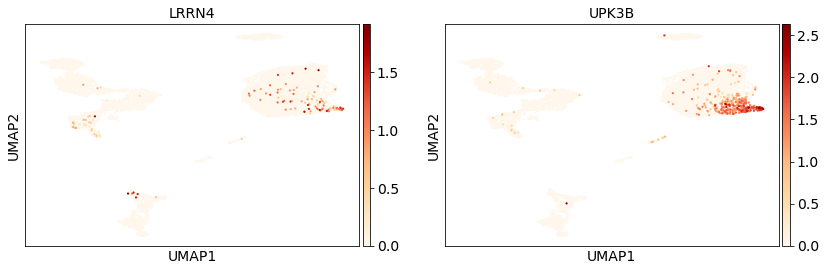

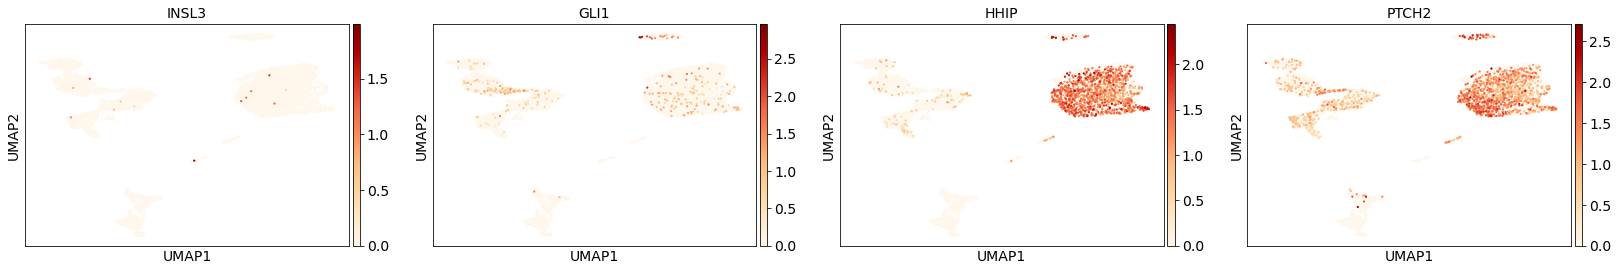

In [47]:
sc.pl.umap(adata, color=["POU5F1", 'DAZL', "STRA8",  "SYCP1", 'FIGLA', 'OOSP2', 'NOBOX'], save='-markers_germcell.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['DCN', 'TCF21', 'COL1A2'], save='-markers_stromal.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['GATA2', 'RSPO3', 'OGN'], save='-markers_stromalExtragonad.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['MMP11', 'LANCL2', 'KCTD8'], save='-markers_stromalGonad.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["WNT6", 'LGR5', "KITLG", 'FOXL2'], save='-markers_supporting.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["EPCAM", "KRT19", 'KLK11', 'PAX8'], save='-markers_epithelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['ASCL1'], save='-markers_neural.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['PECAM1', 'VWF', 'CDH5'], save='-markers_endothelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['PTPRC'], save='-markers_immuneCD45.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["GYPC", "HBA1"], save='-markers_erythroid.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=["PDGFRB", 'ACTA2'], save='-markers_perivascula.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['DES'], save='-markers_smoothmusclecell.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['LGR5'], save='-markers_somaProgenitors.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['LRRN4', 'UPK3B'], save='-markers_mesothelial.pdf',color_map='OrRd', use_raw=False )
sc.pl.umap(adata, color=['INSL3', 'GLI1', 'HHIP', 'PTCH2'], save='-markers_Leydig.pdf',color_map='OrRd', use_raw=False )

### Check global trends

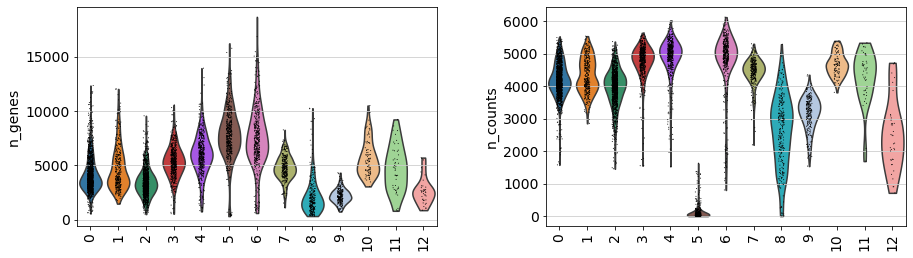

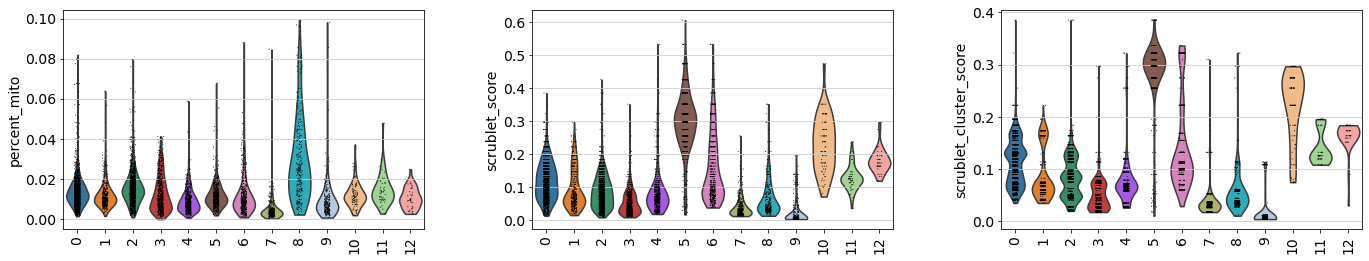

In [48]:
sc.pl.violin(adata, keys= ['n_genes', 'n_counts'], groupby = 'leiden', save='_clusters_statsI.pdf', rotation = 90)
sc.pl.violin(adata, keys= ['percent_mito', 'scrublet_score', 'scrublet_cluster_score'], groupby = 'leiden', save='_clusters_statsII.pdf', rotation = 90)

In [49]:
# Add old cluster subname
meta_som = pd.read_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_female_Hrv58.csv')
meta_som = meta_som.set_index('Unnamed: 0')
meta_som.head()


cell_annot = meta_som['clusters'].to_dict()
adata.obs['previous_lineage'] = adata.obs_names.map(cell_annot)



# Finding marker genes

Compute a ranking for the highly differential genes in each cluster. Here, we simply rank genes with a t test, which agrees quite well with Seurat.

## All vs rest

ranking genes
... storing 'previous_lineage' as categorical
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


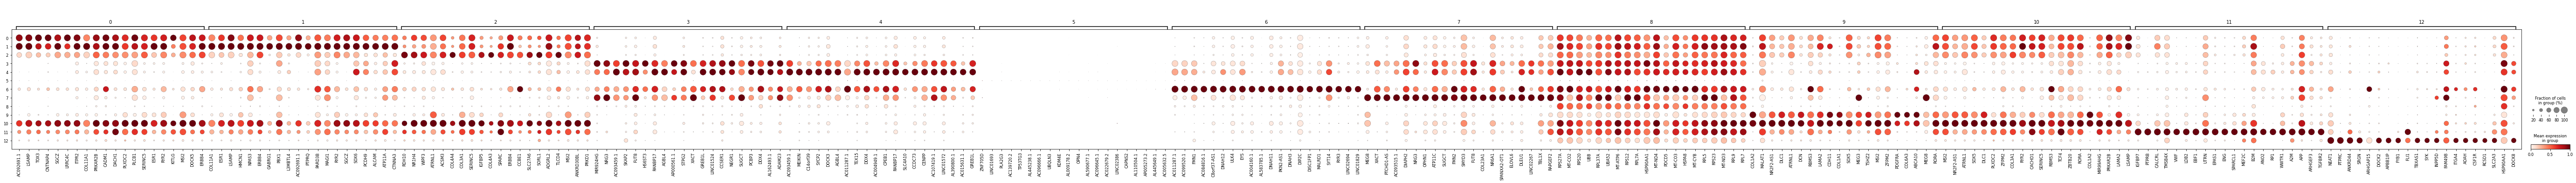

In [50]:
#Compute Mann-Withney test with scanpy
sc.tl.rank_genes_groups(adata, groupby='leiden', use_raw=False) #, method='logreg'
#Plot TF-IDF values
sc.pl.rank_genes_groups_dotplot(adata, n_genes=20, dendrogram=False, save='_scanpy.pdf', standard_scale = 'var')

In [51]:
def Barplot(which_var, adata, var='clusters', height=3, color = False):
    plotdata = pd.crosstab(adata.obs[var], adata.obs[which_var], normalize='index') * 100
    if 'category' in plotdata.index.dtype.name:
        plotdata.index.reorder_categories(adata.obs[var].cat.categories[::-1])

    if not color:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False)
    else:
        ax1 = plotdata.plot.barh(stacked = True, edgecolor = 'none', zorder = 3, figsize = (6,height), fontsize = 14, grid = False, color = color)
    ax1.set_title(which_var+' %')
    ax1.set_ylabel(var)
    horiz_offset = 1
    vert_offset = 1.
    ax1 = ax1.legend(bbox_to_anchor = (horiz_offset, vert_offset))
    ax1.figure.savefig(str(sc.settings.figdir)+'/barplot_'+var+'_proportions_'+which_var+'.pdf', bbox_inches='tight',
                       dpi=300, orientation='landscape', format= 'pdf', optimize=True)

/home/jovyan/my-conda-envs/sc_analysis/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "optimize" which is no longer supported as of 3.3 and will become an error two minor releases later
  app.launch_new_instance()


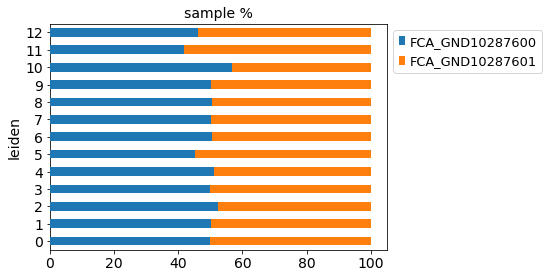

In [52]:
Barplot('sample', adata, var='leiden', height=4)

In [53]:
marker_genes = {
    'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
    'GCs': {'DAZL', 'DDX4'}, 
    'Mesothelial': {'LRRN4', 'LHX2', 'KLK11'},
    'Supporting':{'NR5A1', 'WNT6', 'WIPF3'}, # WNT6, WIPF3, MIR202HG are new
    'preGranulosa':{"KITLG", 'FOXL2', 'IRX3'},
    'Granulosa':{'RDH10'},
    'sPAX8': {"FST", 'PAX8', 'CXCR4'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Sertoli': {'SOX9', 'AMH', 'INHA'},
    'Mesenchymal':{'DCN', 'PDGFRA', 'COL1A1', 'TCF21'},
    'gonadal':{'GATA4', 'LHX9', 'ARX'},
    'extragonadal':{'GATA2', 'NR2F1', 'RSPO3'},
    'uSMCs':{'ACTG2', 'MYH11'},
    'PV': {"PDGFRB", 'ACTA2'},
    'Immune': {'PTPRC'},
    'Endothelial': {'PECAM1', 'VWF', 'CDH5'},
    'Epithelial': {"EPCAM", 'KRT19'},#, 'KRT7', 'CLDN4', 'RAB25'},
    'Erythroid': {"GYPC", "HBA1"},
    'Neural': {'ASCL1', 'ELAVL4', 'PLP1', 'MPZ', 'CHL1'},
    'Erythroid': {"GYPC", "HBA1"},
    'Glomerular mesonephros': {"NPHS2", "CLIC5", "PTPRO"},
    'cycling': {'CDK1', 'MKI67', 'TOP2A'}
}
# marker_genes = {
# #     'Sertoli': {'SOX9', 'INHBB', 'DHH', 'CLDN11'},
#     'mesothelial': {'LRRN4', 'UPK3B'},
#     'Female supporting':{"KITLG", 'FOXL2', 'RSPO1'},
#     'Supporting':{"WNT6", 'NR5A1', 'LHX9', 'GATA4', 'ARX'},
#     'OSE':{'LHX2'},
#     'Stromal':{'COL1A2', 'DCN', 'PDGFRA'},
#     'Stromal_Meso':{'RSPO3', 'GATA2'},
#     'Stromal_Gonad':{'MMP11', 'LANCL2', 'KCTD8'},
# #     'Leydig':{'INSL3', 'GLI1', 'HHIP', 'PTCH2', 'FDX1'},
#     'PGCs': {'POU5F1', 'NANOG', 'NANOS3', 'KIT'},
#     'Germ Cells': {'DAZL', 'SPO11', 'DDX4'},
#     'epithelial': {"EPCAM", "KRT19", 'PAX8'},
#     'neural': {'ASCL1'},
#     'endothelial': {'PECAM1', 'VWF', 'CDH5'},
#     'immune': {'PTPRC'},
#     'erythroid': {"GYPC", "HBA1"},
#     'perivascular': {"PDGFRB", 'ACTA2'},
#     'erythroid': {"GYPC", "HBA1"},
#     'cycling': {'CDK1', 'MKI67', 'TOP2A'}
# }

In [54]:
marker_matches = sc.tl.marker_gene_overlap(adata, marker_genes, method = 'overlap_coef')
marker_matches = marker_matches.set_axis('cl_'+marker_matches.columns, axis=1, inplace=False)

<AxesSubplot:>

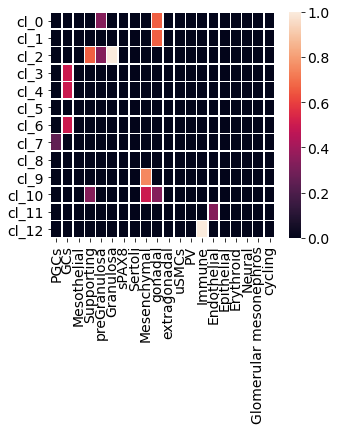

In [55]:
from pandas import DataFrame
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5,4))  
sns.heatmap(marker_matches.T, annot=False, xticklabels=True, yticklabels=True, linewidths=0.5, ax= ax)

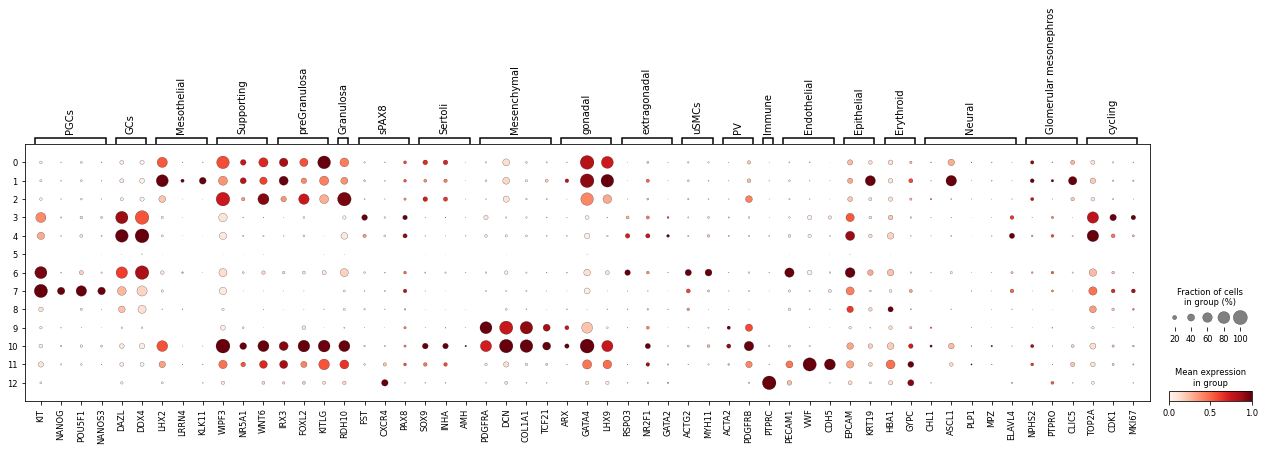

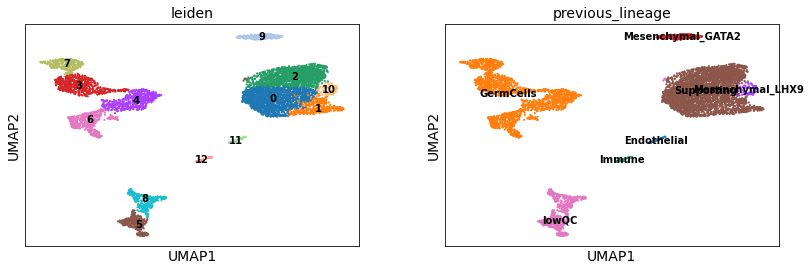

In [56]:
sc.pl.dotplot(adata, marker_genes, groupby='leiden', standard_scale='var')
sc.pl.umap(adata, color=['leiden', 'previous_lineage'],legend_loc='on data')

... storing 'clusters' as categorical


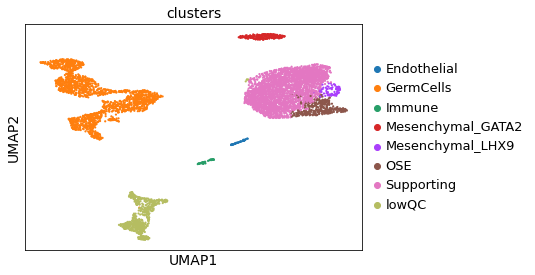

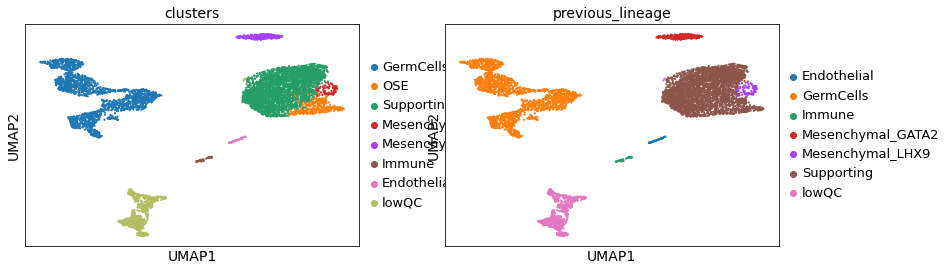

In [58]:
adata.obs['clusters'] = adata.obs['leiden'].tolist()
adata.obs.at[adata.obs['clusters'] == '0', 'clusters'] = 'Supporting'
adata.obs.at[adata.obs['clusters'] == '1', 'clusters'] = 'OSE'
adata.obs.at[adata.obs['clusters'] == '2', 'clusters'] = 'Supporting'
adata.obs.at[adata.obs['clusters'] == '3', 'clusters'] = 'GermCells'
adata.obs.at[adata.obs['clusters'] == '4', 'clusters'] = 'GermCells'
adata.obs.at[adata.obs['clusters'] == '5', 'clusters'] = 'lowQC'
adata.obs.at[adata.obs['clusters'] == '6', 'clusters'] = 'GermCells'
adata.obs.at[adata.obs['clusters'] == '7', 'clusters'] = 'GermCells'
adata.obs.at[adata.obs['clusters'] == '8', 'clusters'] = 'lowQC'
adata.obs.at[adata.obs['clusters'] == '9', 'clusters'] = 'Mesenchymal_GATA2'
adata.obs.at[adata.obs['clusters'] == '10', 'clusters'] = 'Mesenchymal_LHX9'
adata.obs.at[adata.obs['clusters'] == '11', 'clusters'] = 'Endothelial'
adata.obs.at[adata.obs['clusters'] == '12', 'clusters'] = 'Immune'

set(adata.obs['clusters'])
sc.pl.umap(adata, color=['clusters'])
adata.obs['clusters'].cat.reorder_categories(['GermCells', 'OSE', 'Supporting',
                                              'Mesenchymal_LHX9', 'Mesenchymal_GATA2', 
                                              'Immune', 
                                              'Endothelial', 
                                              'lowQC'], inplace=True)

sc.pl.umap(adata, color=['clusters', 'previous_lineage'])

In [59]:
adata.write('mutiomics_female_Hrv58.h5ad')
pd.DataFrame(adata.obs).to_csv('/nfs/team292/lg18/with_valentina/gonadsV2_revision/multiomics_female_Hrv58.csv')